In [1369]:
# !pip install pyts
# !pip install dtaidistance

# Домашнее задание

1. Генерим 21 сигналов (временных рядов), 3 класса по 7 образцов в каждом. 
Постарайтесь сделать их как можно более похожими, и в тоже время различными. 

1. Рассчитываем расстояние между ними по формуле Евклида и с помощью DTW

1. Описываем кратко полученные значения

1. Формируем из нагенеренных временных рядов набор данных для обучения

1. Разбиваем набор на train и test

1. Обучаем  классификаторы KNN с DTW, KNN со стандартной метрикой расстояния, TimeSeriesForest

1. Описываем кратко полученные результаты

In [1370]:
import matplotlib.pyplot as plt
import dtaidistance
import random
import numpy as np
from scipy.spatial.distance import euclidean
import seaborn as sbn

myseed = 1
random.seed(myseed)
np.random.seed(myseed)

Генерация сигнала

1 тип - гармонический (косинус)

2 тип - модифицированный синус

3 тип - пульс - сигнал

Для выполнения дз надо нагенерить 21 сигнал, по 7 сигналов каждого типа

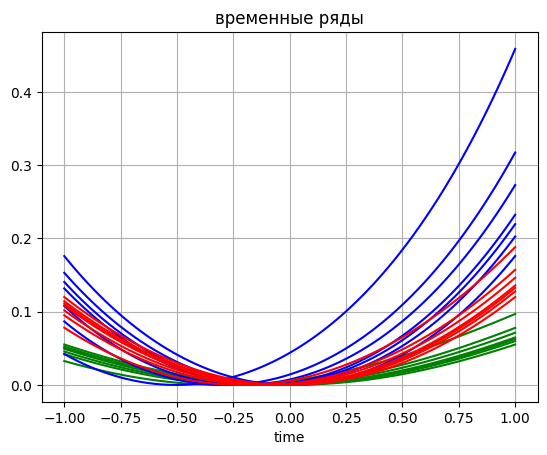

In [1371]:
# индекс и отсчет времени в секундах
time_index = np.linspace(-1, 1, 100)

tseries_list = {'Time': time_index}
step = np.random.random(size=100)

for i in range(7):
    tseries_list["Tc"+str(i)]= (-np.cos(time_index + 0.4 * step[i]) + 1) * 2 * ((step[i] + 6) / 100)

for i in range(7):
    tseries_list["Tch"+str(i)]= (np.cosh(time_index + 0.7 * step[i]) * 0.2 - 0.2) * 9 * ((step[i] + 18) / 100)

for i in range(7):
    tseries_list["Tp"+str(i)]= np.square(time_index + 0.3 * step[i]) * ((step[i] + 12) / 100)


# отрисовка всех сигналов
for i in range(7):
    plt.plot(time_index, tseries_list["Tc"+str(i)], '-g')

for i in range(7):
    plt.plot(time_index, tseries_list["Tch"+str(i)], '-b')

for i in range(7):
    plt.plot(time_index, tseries_list["Tp"+str(i)], '-r')
            
plt.title(r'временные ряды')
plt.xlabel(r'time')
plt.grid()

In [1372]:
# Посчитаем DTW для двух временных рядов

#для простоты выделяем ряды, которые будем сравнивать
tch1 = tseries_list["Tch1"]
tch4 = tseries_list["Tch4"]

tp1 = tseries_list["Tp1"]
tp2 = tseries_list["Tp2"]

tc1 = tseries_list["Tc1"]
tc2 = tseries_list["Tc2"]

print(f"euclidean : ")
print('Tch1 u Tch4 =', euclidean(tch1, tch4))
print('Tp1 u Tp2 =', euclidean(tp1, tp2))
print('Tc1 u Tc2 =', euclidean(tc1, tc2))
print()
print('Ts1 u Tp2 =', euclidean(tch1, tp2))
print('Tp1 u Tc2 =', euclidean(tp1, tc2))
print('Tc1 u Tch4 =', euclidean(tc1, tch4))
print()

print()
print(f"dtw : ")
print('Tch1 u Tch4 =', dtaidistance.dtw.distance(tch1, tch4))
print('Tp1 u Tp2 =', dtaidistance.dtw.distance(tp1, tp2))
print('Tc1 u Tc2 =', dtaidistance.dtw.distance(tc1, tc2))
print()
print('Ts1 u Tp2 =', dtaidistance.dtw.distance(tch1, tp2))
print('Tp1 u Tc2 =', dtaidistance.dtw.distance(tp1, tc2))
print('Tc1 u Tch4 =', dtaidistance.dtw.distance(tc1, tch4))
print()

print('Mean(Euclidean - DTW) = ', np.mean([euclidean(tch1, tch4) - dtaidistance.dtw.distance(tch1, tch4),euclidean(tp1, tp2) - dtaidistance.dtw.distance(tp1, tp2),
                                          euclidean(tc1, tc2) - dtaidistance.dtw.distance(tc1, tc2),euclidean(tch1, tp2) - dtaidistance.dtw.distance(tch1, tp2),
                                          euclidean(tp1, tc2) - dtaidistance.dtw.distance(tp1, tc2),euclidean(tc1, tch4) -  dtaidistance.dtw.distance(tc1, tch4)]))

euclidean : 
Tch1 u Tch4 = 1.0631508905755
Tp1 u Tp2 = 0.33206896532438457
Tc1 u Tc2 = 0.2131240943122805

Ts1 u Tp2 = 1.3708754705854487
Tp1 u Tc2 = 0.48872804728114266
Tc1 u Tch4 = 0.4929524286752976


dtw : 
Tch1 u Tch4 = 0.6598327154318214
Tp1 u Tp2 = 0.16226100815914013
Tc1 u Tc2 = 0.11268655527675327

Ts1 u Tp2 = 1.0682278003547307
Tp1 u Tc2 = 0.3875558366561986
Tc1 u Tch4 = 0.40264969495253394

Mean(Euclidean - DTW) =  0.19461438098714598


#### Из среднего разности видно, что метрика dtw точнее показывает разницу между нашими классами.
#### Вывод лучше использовать ее для наших классов.

In [1373]:
# переделываем датасет так, чтобы с ним можно было бы работать

x = []  #значения
Y = []  # целевая переменная

for v in tseries_list:
    if v!= 'Time':
        x.append(tseries_list[v])
        c = v[:-1]
        if c == "Tch":
            Y.append(0)
        elif c == "Tc":
            Y.append(1)
        else: Y.append(2)


arr = np.arange(len(Y))
np.random.shuffle(arr)


print(Y)

X_train = []
X_test = []
y_train = []
y_test = []

for i in arr[:-6]:
    X_train.append(x[i])
    y_train.append(Y[i])

for i in arr[len(X_train):]:
    X_test.append(x[i])
    y_test.append(Y[i])


[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]


In [1374]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw')
clf.fit(X_train, y_train)

for i in range(len(X_test)):
    print(f"Accuracy {clf.score(X_test, y_test)}")
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Accuracy 1.0
Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2



In [1375]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

for i in range(len(X_test)):
    print(f"Accuracy {clf.score(X_test, y_test)}")
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Accuracy 1.0
Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2



In [1376]:

import numpy as np 
from pyts.classification import TimeSeriesForest
import matplotlib.pyplot as plt

 
clf = TimeSeriesForest(random_state=43)
clf.fit(X_train, y_train)

for i in range(len(X_test)):
    print(f"Accuracy {clf.score(X_test, y_test)}")
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0.04 0.05 0.91]]
Истинный класс для предсказаний 2

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0.028 0.584 0.388]]
Истинный класс для предсказаний 1

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0.932 0.    0.068]]
Истинный класс для предсказаний 0

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0.002 0.986 0.012]]
Истинный класс для предсказаний 1

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0.06  0.168 0.772]]
Истинный класс для предсказаний 2

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0.03  0.044 0.926]]
Истинный класс для предсказаний 2



### Вывод: все модели успешно спрогнозировали классы тестовой выборки, хотя даже человеку будет сложно определить где какой график.
